In [1]:
# Useful starting lines
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../..')

import py_ml.lib as lib

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [2]:
def mse(y, ty):
    e = y - ty
    loss = 1/(2*np.shape(y)[0])*e.dot(e.T)
    return loss

def least_squares(y, tx):
    w = np.linalg.inv(tx.T.dot(tx)).dot(tx.T).dot(y)
    #w = np.linalg.solve(tx, y)
    loss = mse(y, tx.dot(w))
    return loss, w

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [3]:
from helpers import *


def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    
    # Least square
    l_ls, w_ls = least_squares(y, tx)
    
    # Gradient descent
    l_gd, w_gd = lib.gradient_descent(y, tx)
    
    # Stoch. GD
    l_sgd, w_sgd = lib.stochastic_gradient_descent(y, tx)

    # Grid search
    grid_w0, grid_w1 = lib.generate_w(num_intervals=50)
    grid_losses = lib.grid_search(y, tx, grid_w0, grid_w1)
    l_gs, w0_star, w1_star = lib.get_best_parameters(grid_w0, grid_w1, grid_losses)
    w_gs = [w0_star, w1_star]
    
    print('Loss\n LS: {}, GD: {}, SGD: {}, GS: {}'.format(l_ls, l_gd, l_sgd, l_gs))
    print('Weigths (W): \n LS: {}\n GD: {}\n SGD: {}\n GS: {}'.format(w_ls, w_gd, w_sgd, w_gs))

Test it here

In [4]:
test_your_least_squares()

Loss
 LS: 15.385887868829398, GD: 15.385890287459308, SGD: 15.428312229858282, GS: 18.79354101952324
Weigths (W): 
 LS: [ 73.293922    13.47971243]
 GD: [ 73.29197521  13.47935439]
 SGD: [ 73.33848817  13.35366675]
 GS: [71.428571428571416, 15.306122448979579]


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [5]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [6]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    _x = np.ones((np.shape(x)[0], degree+1))
    for i in range(1, degree+1):
        _x[:, i] = x**i
    return _x

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [7]:
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        
        phi = build_poly(x, degree)
        mse, weights = least_squares(y, phi)
        rmse = np.sqrt(2*mse)
        
        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.2585827766773749
Processing 3th experiment, degree=7, rmse=0.24965870360908396
Processing 4th experiment, degree=12, rmse=0.9268294530625559


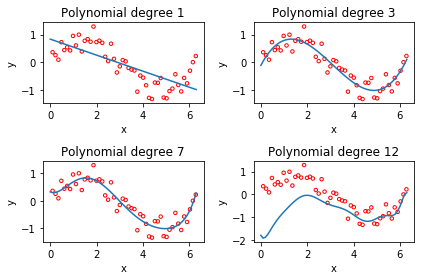

In [8]:
polynomial_regression()

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [9]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    id_keep = np.random.rand(x.shape[0]) <= ratio
    return x[id_keep], x[~id_keep], y[id_keep], y[~id_keep]

Then, test your `split_data` function below.

In [10]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
   
    # Split sets
    x_train, x_test, y_train, y_test = split_data(x, y, ratio, seed)
   
    # Get ploynomial
    phi_train = build_poly(x_train, degree)
    phi_test = build_poly(x_test, degree)
    
    # Least squared
    mse_tr, weights = least_squares(y_train, phi_train)
    mse_te = mse(y_test, phi_test.dot(weights))
    rmse_tr = np.sqrt(2*mse_tr)
    rmse_te = np.sqrt(2*mse_te)
    
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))


In [11]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.478, Testing RMSE=0.424
proportion=0.9, degree=3, Training RMSE=0.263, Testing RMSE=0.226
proportion=0.9, degree=7, Training RMSE=0.249, Testing RMSE=0.286
proportion=0.9, degree=12, Training RMSE=0.351, Testing RMSE=0.383
proportion=0.5, degree=1, Training RMSE=0.502, Testing RMSE=0.466
proportion=0.5, degree=3, Training RMSE=0.196, Testing RMSE=0.349
proportion=0.5, degree=7, Training RMSE=0.186, Testing RMSE=1.282
proportion=0.5, degree=12, Training RMSE=0.497, Testing RMSE=1.941
proportion=0.1, degree=1, Training RMSE=0.128, Testing RMSE=0.643
proportion=0.1, degree=3, Training RMSE=0.357, Testing RMSE=4.651
proportion=0.1, degree=7, Training RMSE=1.497, Testing RMSE=5.582
proportion=0.1, degree=12, Training RMSE=8.051, Testing RMSE=557.598


# 3 Ridge Regression
Please fill in the function below.

In [12]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    
    Lambda_ = lambda_*np.eye(tx.shape[1])
    w = np.linalg.inv(tx.T.dot(tx) + Lambda_.T.dot(Lambda_)).dot(tx.T).dot(y)
    loss = mse(y, tx.dot(w))
    return loss, w

In [13]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    
    # Split sets
    x_train, x_test, y_train, y_test = split_data(x, y, ratio, seed)
    
    # Get ploynomial
    phi_train = build_poly(x_train, degree)
    phi_test = build_poly(x_test, degree)

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        
        mse_tr, weights = ridge_regression(y_train, phi_train, lambda_)
        mse_te = mse(y_test, phi_test.dot(weights))
        rmse_tr.append(np.sqrt(2*mse_tr))
        rmse_te.append(np.sqrt(2*mse_te))
    
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)



proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.220, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.220, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.220, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.220, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.220, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.220, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.220, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.220, Testing RMSE=0.335
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.220, Testing RMSE=0.331
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.221, Testing RMSE=0.317
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.227, Testing RMSE=0.291
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.236, Testing RMSE=0.276
proportion=0.5, degree=7, lambda=0.193, 

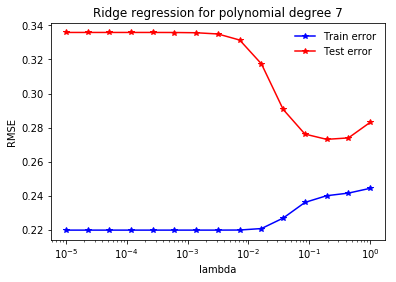

In [14]:
seed = 9 # 26
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)